# ArrNet:

The ArrNet model takes in a 30 second seismic waveform and outputs a refined onset time estimate, along with a set of confidence intervals. This is accomplished by utilizing a TCN architecture, trained with quantile loss.

This notebook is a releasable demo, that shows how to instantiate and train the model. The model is trained using the FDSN service to pull waveforms from the internet at each batch, removing the need to store a large dataset locally.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import obspy
from obspy.clients.fdsn import Client

from ArrNet import ArrNet
from model_utils import Params, DAT_normalize, DAT_filter, get_wav
from model_utils import save_dict_to_json
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback

import obspy
from obspy.clients.fdsn import Client

!pip install -e .

distutils: /home/dickey/anaconda3/envs/aiml/include/python3.8/UNKNOWN
sysconfig: /home/dickey/anaconda3/envs/aiml/include/python3.8
user = False
home = None
root = None
prefix = None
Obtaining file:///media/HDD2/PycharmProjects/ArrNet/arr-net-main%281%29/arr-net-main
  Attempting uninstall: sdea
    Found existing installation: sdea 0.0.0
    Uninstalling sdea-0.0.0:
      Successfully uninstalled sdea-0.0.0
  Running setup.py develop for sdea
distutils: /home/dickey/anaconda3/envs/aiml/include/python3.8/UNKNOWN
sysconfig: /home/dickey/anaconda3/envs/aiml/include/python3.8
user = False
home = None
root = None
prefix = None


# Setup:

The model is instantiated via a parameter file. This parameter file defines the hyperparameters of the architecture, the preprocessing specifications of the datasetas, and the directory locations for saving files/models/etc. In the code below, we load in the default parameter file and setup the local directories.

In [2]:
CATALOG_SOURCE = 'USArray_07-13.zip'
WAVEFORM_SOURCE = Client('IRIS')

# Call the get_default_par method to save a set of default parameters in a json file.
# All hyperparameters for the network are controlled by setting values in this par file.

params = ArrNet.get_default_par(os.path.join('.', 'test_par.json'))

if not os.path.exists(params.model_folder):
    os.mkdir(params.model_folder)
if not os.path.exists(params.log_folder):
    os.mkdir(params.log_folder)
if not os.path.exists(params.data_folder):
    os.mkdir(params.data_folder)    
if not os.path.exists(params.image_folder):
    os.mkdir(params.image_folder) 
    
params.bs = 32
params

lr             : 0.001
bs             : 32
loss           : quantile
optimizer      : adam
f_low          : 0.8
f_high         : 4.5
f_pad          : 3
cmpts          : Z
s_rate         : 40
w_len          : 30
shift          : 5
f              : 45
d              : [2, 4, 8, 16, 32]
k              : 20
s              : 3
dense          : [64, 64]
pat            : 20
t_step         : 64
v_step         : 64
cmps           : B
zp             : False
project_name   : 
model_name     : lr:0.001|bs:32|loss:quantile|optimizer:adam|f_low:0.8|f_high:4.5|f_pad:3|cmpts:Z|s_rate:40|w_len:30|shift:5|f:45|d:2x4x8x16x32|k:20|s:3|dense:64x64|pat:20|t_step:64|v_step:64|cmps:B|zp:False|trnRET:False|type:tcn|quantiles:0.9772x0.8413x0.1538x0.0228
model_file     : 
model_save     : 
log_folder     : logs/
data_folder    : data/
image_folder   : images/
model_folder   : models/
trnRET         : False
catalog        : 
type           : tcn
quantiles      : [0.9772, 0.8413, 0.1538, 0.0228]



# Dataset:

The first thing we need to do is to establish the train/val/test datasets. This is done via a generator function, which takes in an arrival catalog and yields an X,Y minibatch. The X contains an array of waveform data with shape (batch_size, samples). The Y contains a vector of onset labels with shape (batch_size, 1). To be clear, the onset labels are scalar values indicating the seconds deviation of the onset from the middle of the waveform.

The generator function is listed below:





In [3]:
def gen(cat, pdict, source, val=False):
    '''
    cat: a pandas dataframe containing the arrival catalog to be used for generating examples
    pdict: a parameter file containing the following variables...
        s_rate: the sample rate of the waveforms (must be standard across catalog)
        w_len: the window length in seconds of each example
        cmpts: a string containing the channels to be used, ie - 'Z' or 'ZNE'
        shift: the time in seconds to perturb the onset times from the center of the waveform
        bs: the number of examples in each minibatch
        f_pad: extra seconds of waveform to download (trimmed after filtering to eliminate filter transients)
    source: an obspy Client to the FDSN service for downloading waveforms
    val: if true, generator also yields the corresponding catalog entries
        
    '''
    
    bs = pdict.bs
    w_len_samps = int(pdict.s_rate * pdict.w_len)
    nb_chans = len(pdict.cmpts)
    p_len_samps = pdict.f_pad*pdict.s_rate
    
    while 1:
        random.seed()
        X = np.zeros((bs, w_len_samps + 2*p_len_samps, nb_chans))
        Y = np.random.uniform(low=-pdict.shift, high=pdict.shift, size=(bs, 1))
        df = pd.DataFrame() 
        
        batch_counter = 0

        while batch_counter < bs:

            try:
                rec = cat.iloc[random.randint(0,len(cat))]
                sta = rec.STA
                time = rec.TIME + pd.Timedelta(Y[batch_counter, 0], 's')
                st = time - pd.Timedelta(pdict.w_len / 2 + pdict.f_pad, 's')
                en = time + pd.Timedelta(pdict.w_len / 2 + pdict.f_pad, 's')
                trace = get_wav(sta, st, en, pdict, source)

                X[batch_counter] = trace[:w_len_samps + 2*p_len_samps]
                batch_counter += 1
                if val: df = df.append(rec)
                    
            except:
                pass

        X = DAT_normalize(DAT_filter(X, pdict)[:,p_len_samps:-p_len_samps,:])
        if val: yield X, Y, df
        else:   yield X, Y


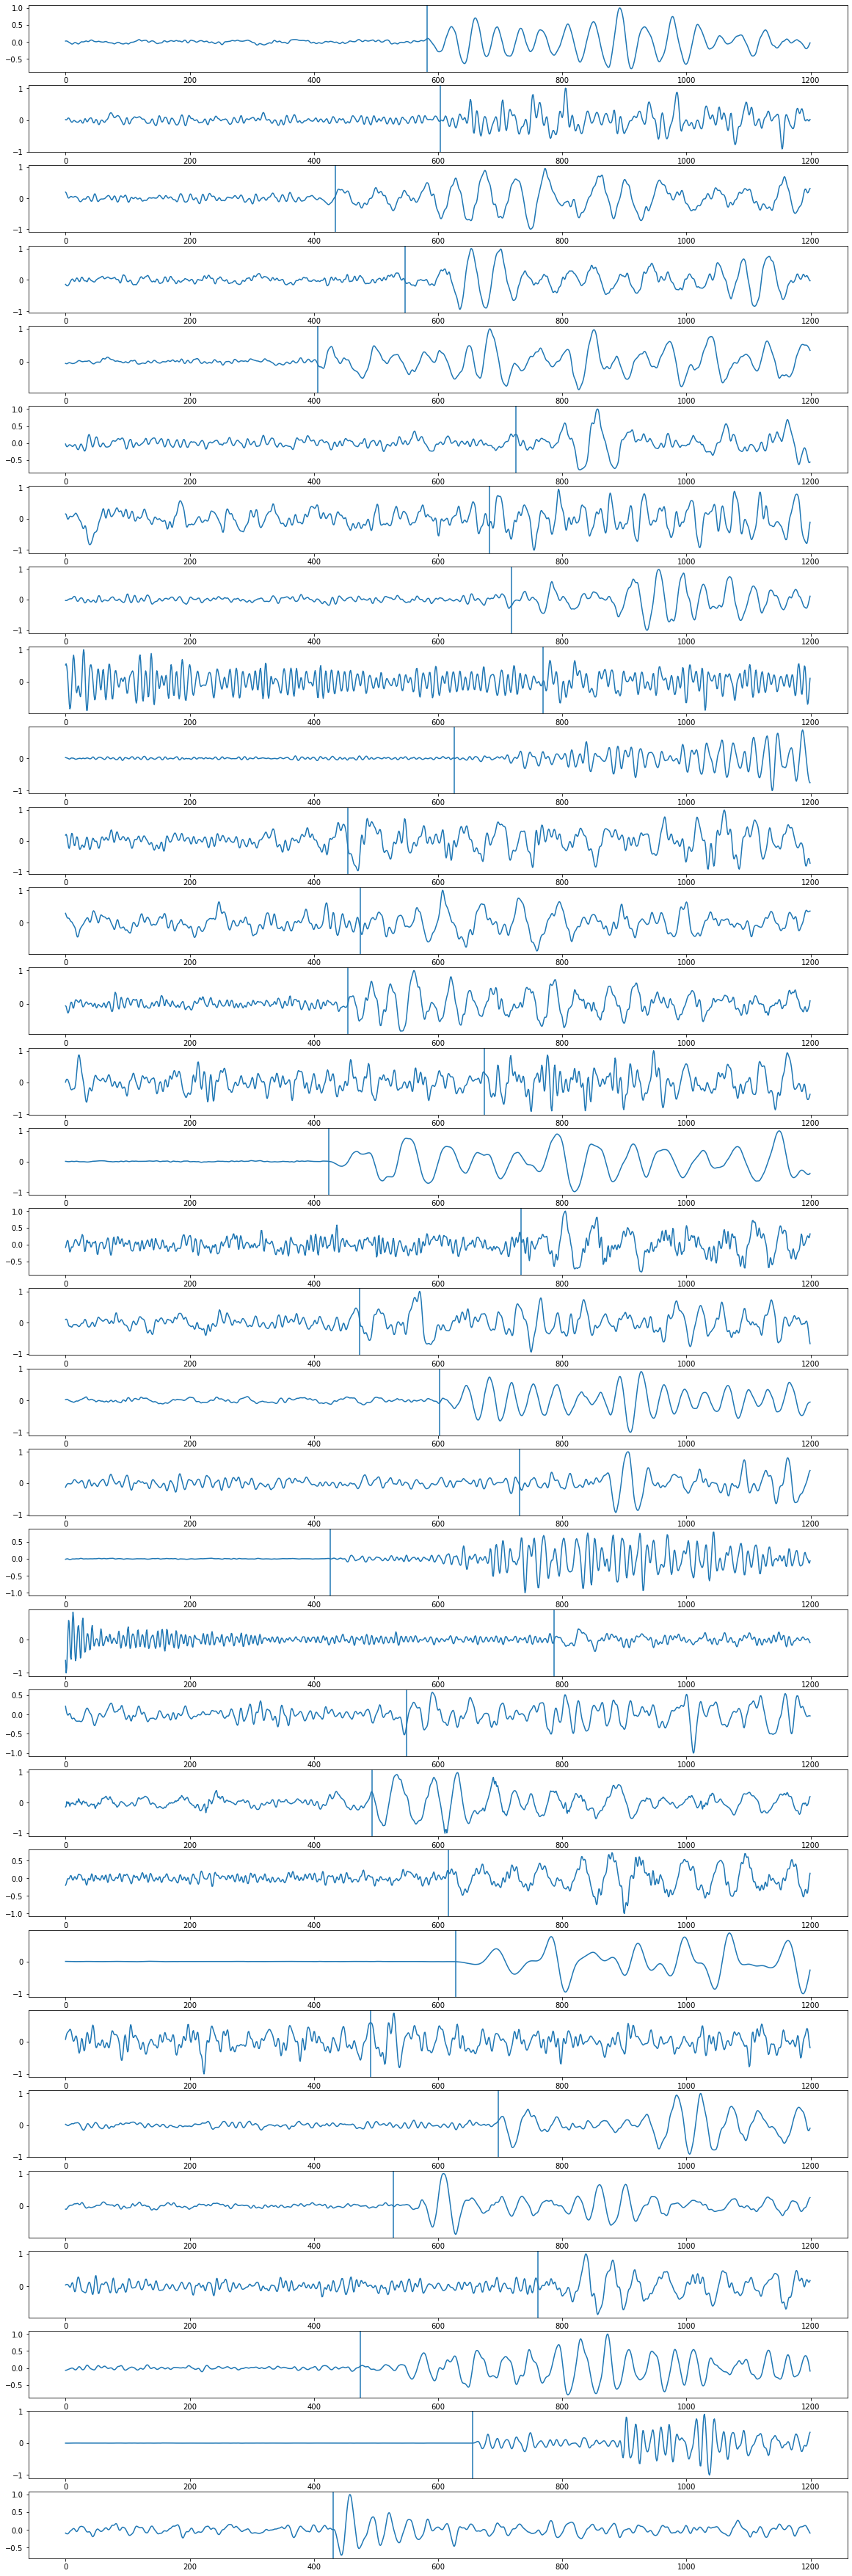

In [4]:
# read in the catalog of arrivals
cat = pd.read_pickle(CATALOG_SOURCE)

# build the generators
cat_trn = cat.loc[(cat.TIME < '2010-01-01')]
cat_val = cat.loc[(cat.TIME > '2010-01-01') & (cat.TIME < '2012-01-01')]
cat_tst = cat.loc[(cat.TIME > '2012-01-01')]
                   
gen_trn = gen(cat_trn, params, WAVEFORM_SOURCE)
gen_val = gen(cat_val, params, WAVEFORM_SOURCE, val=True)
gen_tst = gen(cat_tst, params, WAVEFORM_SOURCE, val=True)

# plot some waveforms 
X, Y = next(gen_trn)

nb_plot = params.bs
fig, ax = plt.subplots(nb_plot, 1, figsize=(20,nb_plot*2))
for i in range(nb_plot):
    ax[i].plot(X[i])
    ax[i].axvline(params.s_rate*(params.w_len/2 - Y[i]))

It is often convenient to have a static validation set, so that training curves can be less stochastic. The code below builds the validation set. 

In [5]:
my_model_name = 'default_model'

# build a static validation set
x_file = os.path.join(params.data_folder, f'x_{my_model_name}.npy')
y_file = os.path.join(params.data_folder, f'y_{my_model_name}.npy')
cat_file = os.path.join(params.data_folder, f'cat_{my_model_name}.zip') 

if os.path.exists(cat_file):
    
    X_val = np.load(x_file)
    Y_val = np.load(y_file)
    cat_val = pd.read_pickle(cat_file)
    
else:
    print('Creating Vaildation Set...')
    X_val = []
    Y_val = []
    cat_val = []
    
    for i in range(params.v_step):   
        print(f'{i}/{params.v_step}:')
        my_X, my_Y, my_cat = next(gen_val)
        X_val.append(my_X)
        Y_val.append(my_Y)
        cat_val.append(my_cat)
        
    X_val = np.vstack(X_val)
    Y_val = np.vstack(Y_val)
    cat_val = pd.concat(cat_val)
    
    np.save(x_file, X_val)
    np.save(y_file, Y_val)
    cat_val.to_csv(cat_file)

# Model:

We now build the ArrNet model and initiate a training run.

In [6]:
# Create a model using the previously created params.
# Settings can be adjusted in the parameters by setting the values
# Ex. params.lr = 0.0001
model = ArrNet.get_network(params)
model.summary()

Model: "q_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 45)     945         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, 45)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 45)     0           activation[0][0]                 
____________________________________________________________________________________________

In [7]:
def get_callbacks(pdict):
    tensor_foldername = os.path.join(pdict.log_folder, pdict.model_name)
    if not os.path.exists(tensor_foldername):
        os.mkdir(tensor_foldername) 
    model_filename = os.path.join(pdict.model_folder, pdict.model_name + '.h5')
                      
    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                         save_weights_only=False, mode='min')
    tbd = TensorBoard(log_dir=tensor_foldername)
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict.pat,
                        verbose=0, mode='min', baseline=None)

    return [sv, tbd, stp]

In [8]:
# TRAIN!
my_hist = model.fit(x=gen_trn, steps_per_epoch=64, epochs=5000,
                    validation_data=(X_val, Y_val),
                    use_multiprocessing=True,
                    callbacks=get_callbacks(params),
                    workers=8, max_queue_size=128)

Epoch 1/5000
64/64 [==============================] - 194s 3s/step - loss: 3.9106 - huber_loss: 1.4553 - output_97_loss: 0.3595 - output_84_loss: 0.7068 - output_15_loss: 0.8075 - output_02_loss: 0.5815 - huber_mean_absolute_error: 1.8963 - output_97_mean_absolute_error: 4.2203 - output_84_mean_absolute_error: 2.6819 - output_15_mean_absolute_error: 2.7362 - output_02_mean_absolute_error: 3.7542 - val_loss: 2.3927 - val_huber_loss: 1.0614 - val_output_97_loss: 0.2369 - val_output_84_loss: 0.5703 - val_output_15_loss: 0.4240 - val_output_02_loss: 0.1002 - val_huber_mean_absolute_error: 1.4915 - val_output_97_mean_absolute_error: 2.8999 - val_output_84_mean_absolute_error: 1.8660 - val_output_15_mean_absolute_error: 1.9455 - val_output_02_mean_absolute_error: 3.2201
Epoch 2/5000
64/64 [==============================] - 214s 3s/step - loss: 2.0059 - huber_loss: 0.8777 - output_97_loss: 0.1395 - output_84_loss: 0.4467 - output_15_loss: 0.4259 - output_02_loss: 0.1161 - huber_mean_absolute_

64/64 [==============================] - 213s 3s/step - loss: 1.4103 - huber_loss: 0.5605 - output_97_loss: 0.1130 - output_84_loss: 0.3434 - output_15_loss: 0.3026 - output_02_loss: 0.0908 - huber_mean_absolute_error: 0.9317 - output_97_mean_absolute_error: 3.4562 - output_84_mean_absolute_error: 1.4598 - output_15_mean_absolute_error: 1.3466 - output_02_mean_absolute_error: 2.7469 - val_loss: 1.6604 - val_huber_loss: 0.7343 - val_output_97_loss: 0.1180 - val_output_84_loss: 0.4034 - val_output_15_loss: 0.3185 - val_output_02_loss: 0.0862 - val_huber_mean_absolute_error: 1.1265 - val_output_97_mean_absolute_error: 3.5796 - val_output_84_mean_absolute_error: 1.7925 - val_output_15_mean_absolute_error: 1.3841 - val_output_02_mean_absolute_error: 2.4608
Epoch 12/5000
64/64 [==============================] - 207s 3s/step - loss: 1.3095 - huber_loss: 0.5345 - output_97_loss: 0.1060 - output_84_loss: 0.3292 - output_15_loss: 0.2669 - output_02_loss: 0.0729 - huber_mean_absolute_error: 0.903

Epoch 22/5000
64/64 [==============================] - 202s 3s/step - loss: 1.3530 - huber_loss: 0.5550 - output_97_loss: 0.1134 - output_84_loss: 0.3349 - output_15_loss: 0.2715 - output_02_loss: 0.0781 - huber_mean_absolute_error: 0.9090 - output_97_mean_absolute_error: 3.3317 - output_84_mean_absolute_error: 1.3691 - output_15_mean_absolute_error: 1.2941 - output_02_mean_absolute_error: 2.5388 - val_loss: 1.5717 - val_huber_loss: 0.6799 - val_output_97_loss: 0.1136 - val_output_84_loss: 0.4000 - val_output_15_loss: 0.2913 - val_output_02_loss: 0.0869 - val_huber_mean_absolute_error: 1.0618 - val_output_97_mean_absolute_error: 3.0691 - val_output_84_mean_absolute_error: 1.3429 - val_output_15_mean_absolute_error: 1.2072 - val_output_02_mean_absolute_error: 2.2397
Epoch 23/5000
64/64 [==============================] - 210s 3s/step - loss: 1.1972 - huber_loss: 0.4818 - output_97_loss: 0.0875 - output_84_loss: 0.2962 - output_15_loss: 0.2590 - output_02_loss: 0.0727 - huber_mean_absolut

Epoch 33/5000
64/64 [==============================] - 212s 3s/step - loss: 1.2793 - huber_loss: 0.5208 - output_97_loss: 0.1107 - output_84_loss: 0.3315 - output_15_loss: 0.2438 - output_02_loss: 0.0725 - huber_mean_absolute_error: 0.8716 - output_97_mean_absolute_error: 3.0464 - output_84_mean_absolute_error: 1.2612 - output_15_mean_absolute_error: 1.2279 - output_02_mean_absolute_error: 2.3472 - val_loss: 1.6003 - val_huber_loss: 0.7202 - val_output_97_loss: 0.1180 - val_output_84_loss: 0.4114 - val_output_15_loss: 0.2806 - val_output_02_loss: 0.0702 - val_huber_mean_absolute_error: 1.0992 - val_output_97_mean_absolute_error: 3.2648 - val_output_84_mean_absolute_error: 1.5258 - val_output_15_mean_absolute_error: 1.2987 - val_output_02_mean_absolute_error: 2.3399
Epoch 34/5000
64/64 [==============================] - 208s 3s/step - loss: 1.2564 - huber_loss: 0.5191 - output_97_loss: 0.1007 - output_84_loss: 0.3174 - output_15_loss: 0.2484 - output_02_loss: 0.0708 - huber_mean_absolut

Epoch 44/5000
64/64 [==============================] - 204s 3s/step - loss: 1.2744 - huber_loss: 0.5323 - output_97_loss: 0.1046 - output_84_loss: 0.3209 - output_15_loss: 0.2507 - output_02_loss: 0.0657 - huber_mean_absolute_error: 0.8894 - output_97_mean_absolute_error: 2.6335 - output_84_mean_absolute_error: 1.2014 - output_15_mean_absolute_error: 1.2916 - output_02_mean_absolute_error: 2.2901 - val_loss: 1.5474 - val_huber_loss: 0.6793 - val_output_97_loss: 0.0958 - val_output_84_loss: 0.3608 - val_output_15_loss: 0.3175 - val_output_02_loss: 0.0941 - val_huber_mean_absolute_error: 1.0450 - val_output_97_mean_absolute_error: 2.9913 - val_output_84_mean_absolute_error: 1.5432 - val_output_15_mean_absolute_error: 1.1302 - val_output_02_mean_absolute_error: 1.8589
Epoch 45/5000
64/64 [==============================] - 209s 3s/step - loss: 1.2310 - huber_loss: 0.5151 - output_97_loss: 0.0898 - output_84_loss: 0.3092 - output_15_loss: 0.2507 - output_02_loss: 0.0663 - huber_mean_absolut

Epoch 55/5000
64/64 [==============================] - 206s 3s/step - loss: 1.1572 - huber_loss: 0.4713 - output_97_loss: 0.0891 - output_84_loss: 0.2875 - output_15_loss: 0.2397 - output_02_loss: 0.0696 - huber_mean_absolute_error: 0.8091 - output_97_mean_absolute_error: 2.7928 - output_84_mean_absolute_error: 1.1918 - output_15_mean_absolute_error: 1.1497 - output_02_mean_absolute_error: 2.0640 - val_loss: 1.5334 - val_huber_loss: 0.7050 - val_output_97_loss: 0.1037 - val_output_84_loss: 0.3790 - val_output_15_loss: 0.2840 - val_output_02_loss: 0.0617 - val_huber_mean_absolute_error: 1.0885 - val_output_97_mean_absolute_error: 2.9721 - val_output_84_mean_absolute_error: 1.3057 - val_output_15_mean_absolute_error: 1.4642 - val_output_02_mean_absolute_error: 2.4475
Epoch 56/5000
64/64 [==============================] - 214s 3s/step - loss: 1.1524 - huber_loss: 0.4626 - output_97_loss: 0.0995 - output_84_loss: 0.2987 - output_15_loss: 0.2295 - output_02_loss: 0.0620 - huber_mean_absolut

# Testing:

In [24]:
def o2s(offset):
    return params.s_rate*(params.w_len/2 - offset)

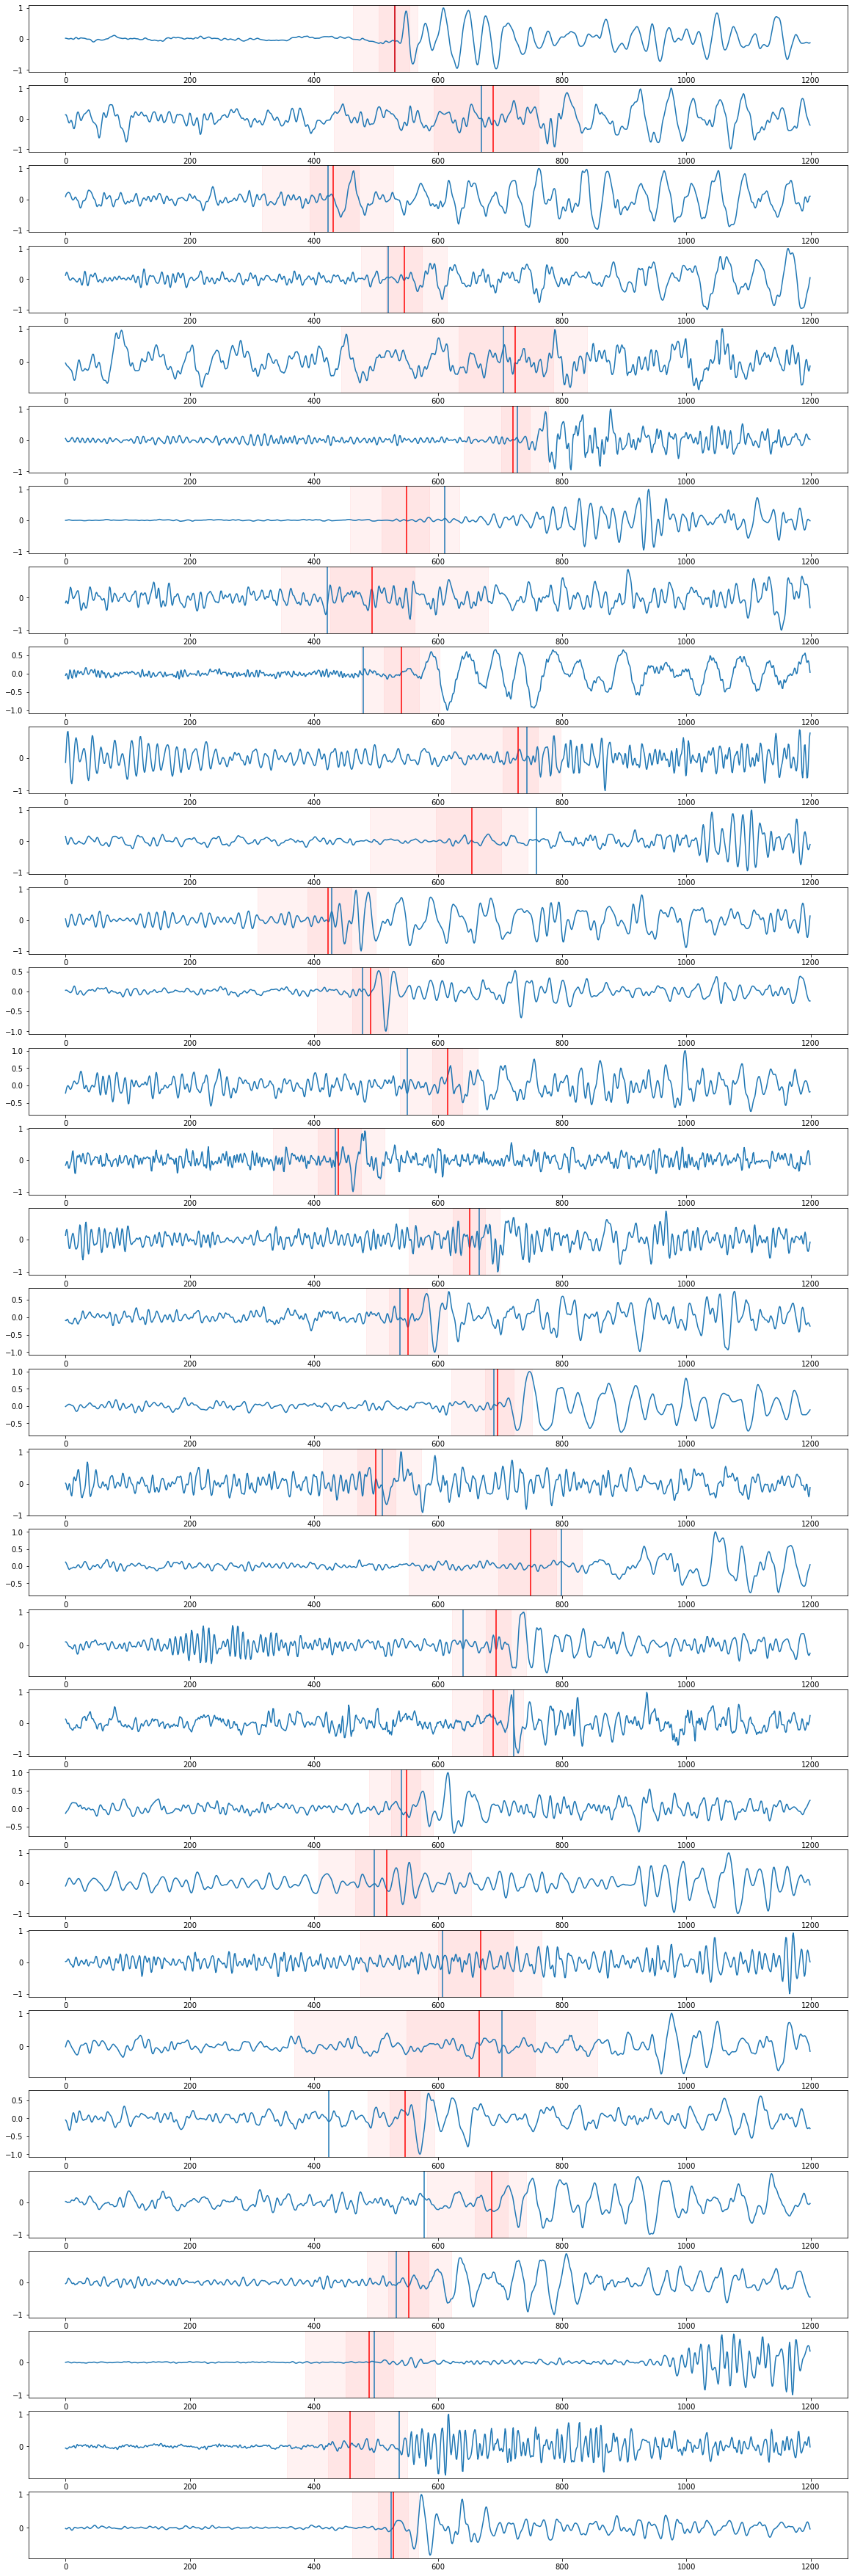

In [42]:
# plot some waveforms 
X_tst, Y_tst, cat_tst = next(gen_tst)
Y_pred = model.predict(X_tst)
nb_plot = params.bs
fig, ax = plt.subplots(nb_plot, 1, figsize=(20,nb_plot*2))
for i in range(nb_plot):
    ax[i].plot(X_tst[i])
    ax[i].axvline(o2s(Y_tst[i]))
    ax[i].axvline(o2s(Y_pred[0][i].copy()), c='red')
    ax[i].axvspan(o2s(Y_pred[1][i][0]), o2s(Y_pred[4][i][0]), color='red', alpha=0.05)
    ax[i].axvspan(o2s(Y_pred[2][i][0]), o2s(Y_pred[3][i][0]), color='red', alpha=0.05)